## Reduced Rank Regression

In [1]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Load the data
current_dir = os.getcwd()
print("Loading the data...")
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')
print("Data loaded successfully!")

Loading the data...
Data loaded successfully!


In [3]:
filtered_data = filter_data(data)

100%|██████████| 72/72 [00:00<00:00, 61380.06it/s]


In [4]:
# Print the shape of the first run in the first model of filtered_data
first_model = list(filtered_data.keys())[0]
first_run = list(filtered_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {filtered_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


In [5]:
# Create a NaN mask to remove any cells which have 1 >= NaNs

nan_mask = create_nan_mask(filtered_data)

100%|██████████| 34/34 [00:02<00:00, 16.18it/s]


In [6]:
# Apply the NaN mask to every single run (modifications done in place for memory efficiency)

masked_data = mask_out_nans(filtered_data, nan_mask)

100%|██████████| 34/34 [00:01<00:00, 24.21it/s]


In [7]:
# Print the shape of the first run in the first model of masked_data
first_model = list(masked_data.keys())[0]
first_run = list(masked_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {masked_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [8]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


In [9]:
reshaped_data = reshape_data(masked_data)

100%|██████████| 34/34 [00:03<00:00,  8.99it/s]


In [10]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [11]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [12]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


In [13]:
# Print the shape of a random run from a random model

random_model = random.choice(list(data_forced_responses.keys()))
random_run = random.choice(list(data_forced_responses[random_model].keys()))
print(f"Shape of the random run: {data_forced_responses[random_model][random_run].shape}")

Shape of the random run: (165, 10368)


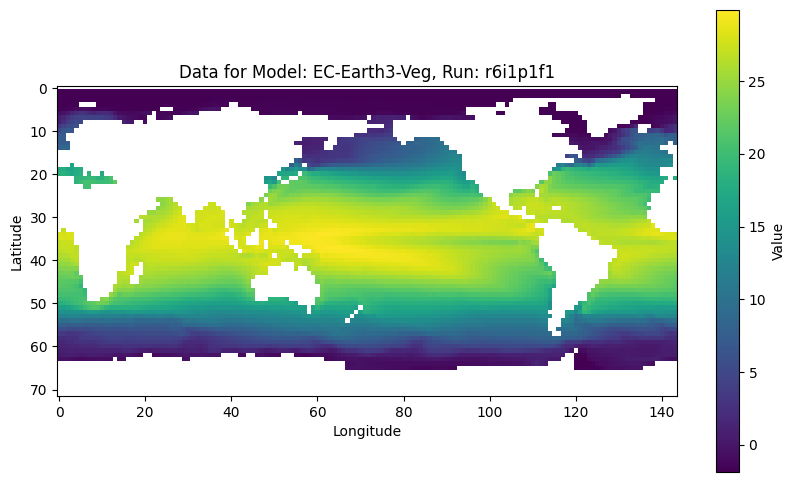

In [14]:
# Reshape the data to the original grid shape
data_grid = data_forced_responses[random_model][random_run][0].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(10, 6))
plt.imshow(data_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Data for Model: {random_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## At this point, the data still contains NaNs, corresponding to the continents

In [15]:
data_without_nans = remove_nans_from_grid(data_forced_responses, nan_mask)

100%|██████████| 34/34 [00:01<00:00, 30.57it/s]


In [16]:
# Print the shape of a random run from a random model (same as above)
print(f"The shape of the data without NaNs: {data_without_nans[random_model][random_run].shape}")

The shape of the data without NaNs: (165, 6523)


## Now the NaNs have been completely removed from the data

### The data is now in the shape : Time x # of grid cells without NaNs

In [17]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data_without_nans.keys()))
train_models = [model for model in data_without_nans.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2']
Testing model: GISS-E2-2-H


  0%|          | 0/1 [00:00<?, ?it/s]

Normalizing test data for model GISS-E2-2-H
data normalized


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

Completed normalization for model GISS-E2-2-H
Data normalization completed.


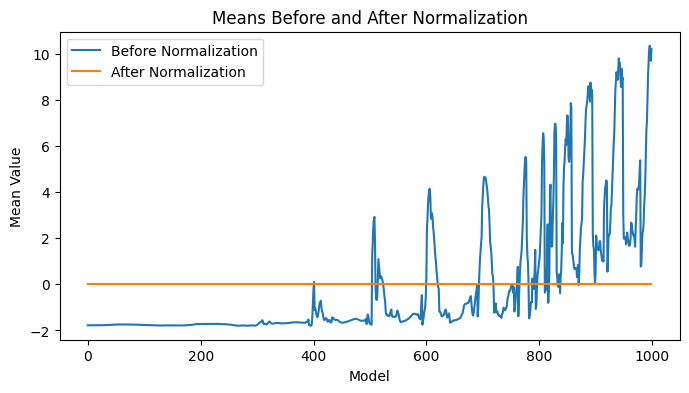

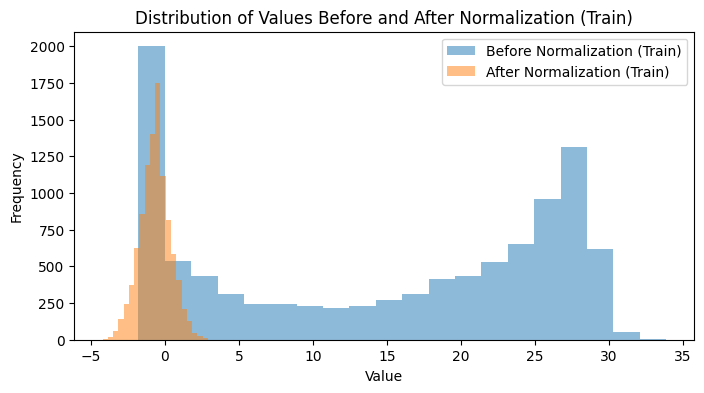

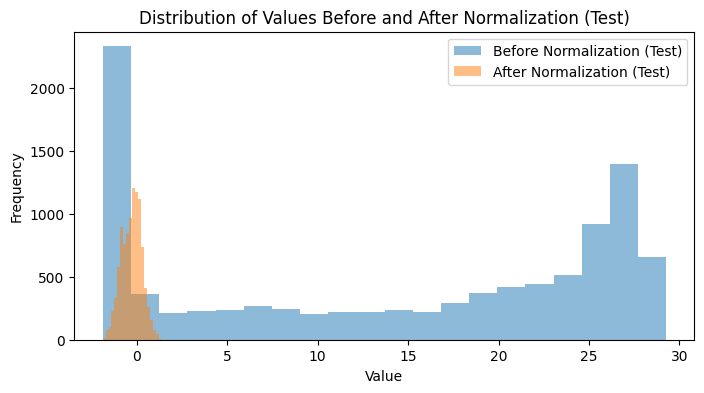

In [18]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)